# Time Series ML Model for Predicting Women Crimes in India (2021-2030)

- Note: This notebook aggregates total_cases by year at the national level.
- We use ARIMA from statsmodels for time series forecasting.
-  Handling COVID anomaly: We'll fit the model on data up to 2019, predict 2020 (which decreased due to COVID),
-  then refit including 2021 (which increased) to forecast 2022-2030.
- Assumptions: Data loaded from the provided Excel file. Ensure the file is in the working directory.
- Libraries available: pandas, numpy, matplotlib, statsmodels.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import adfuller

In [ ]:
url = 'https://drive.google.com/uc?export=download&id=1j8tOcMfhRZPL1ijwYX3AMc6iuy_Udnve'
df = pd.read_csv(url)
df


,year,state,district,rape,attempt_to_rape,gang_rape,murder_with_rape,kidnapping_and_abduction,dowry_deaths,dowry_prohibition_act,...,abduction_for_illicit_intercourse,attempt_to_kidnap,domestic_violence_act_cases,abetment_to_suicide_women,attempt_to_murder_women,insult_outraging_modesty_other,sexual_harassment_workplace,dowry_harassment,marital_rape_reports,total_cases
0,2001,Andhra Pradesh,Andhra District 1,3,7,3,5,11,4,12,...,8,8,10,4,4,5,5,2,3,512
1,2001,Andhra Pradesh,Andhra District 2,3,4,5,6,9,4,5,...,4,4,6,7,3,2,4,7,6,497
2,2001,Andhra Pradesh,Andhra District 3,3,6,4,7,13,5,5,...,2,6,5,6,6,3,3,5,2,511
3,2001,Andhra Pradesh,Andhra District 4,2,8,4,7,20,1,4,...,5,5,6,7,6,7,3,2,3,476
4,2001,Andhra Pradesh,Andhra District 5,2,7,4,9,15,4,7,...,9,6,0,4,3,6,8,0,3,506
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,2020,Mizoram,Mizoram District 10,21,14,9,22,43,20,20,...,28,13,11,14,24,19,16,19,16,1731
9996,2020,Mizoram,Mizoram District 11,23,14,12,17,32,24,25,...,19,14,22,14,16,23,15,17,19,1676
9997,2020,Mizoram,Mizoram District 12,28,33,21,16,29,18,19,...,21,13,11,20,15,14,14,26,18,1754
9998,2020,Mizoram,Mizoram District 13,18,14,15,15,29,17,22,...,23,19,18,23,15,30,15,20,15,1756


In [ ]:
print("Data shape:", df.shape)
print("\nUnique years:", sorted(df['year'].unique()))

Data shape: (10000, 44)

Unique years: [np.int64(2001), np.int64(2002), np.int64(2003), np.int64(2004), np.int64(2005), np.int64(2006), np.int64(2007), np.int64(2008), np.int64(2009), np.int64(2010), np.int64(2011), np.int64(2012), np.int64(2013), np.int64(2014), np.int64(2015), np.int64(2016), np.int64(2017), np.int64(2018), np.int64(2019), np.int64(2020)]


## Step 2: Aggregate total_cases by year (national level)

In [ ]:
yearly_total = df.groupby('year')['total_cases'].sum()
print("\nYearly total cases:")
print(yearly_total)


Yearly total cases:
year
2001    757967
2002    763524
2003    775071
2004    785046
2005    794331
2006    801144
2007    813722
2008    821675
2009    830906
2010    838001
2011    849040
2012    858649
2013    866685
2014    877467
2015    887537
2016    894010
2017    905258
2018    912913
2019    922892
2020    391410
Name: total_cases, dtype: int64


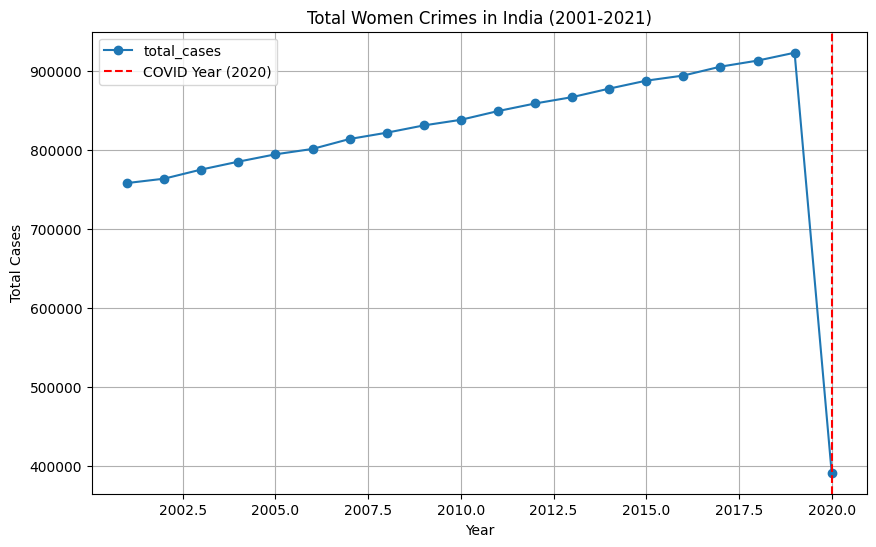

In [ ]:
# Step 3: Visualize the time series
plt.figure(figsize=(10, 6))
yearly_total.plot(kind='line', marker='o')
plt.title('Total Women Crimes in India (2001-2021)')
plt.xlabel('Year')
plt.ylabel('Total Cases')
plt.grid(True)
plt.axvline(x=2020, color='r', linestyle='--', label='COVID Year (2020)')
plt.legend()
plt.show()

# Check for stationarity (ADF test)

## Augmented Dickey-Fuller (ADF) Test

The Augmented Dickey-Fuller (ADF) test is a statistical test used to determine if a time series is stationary. A stationary time series is one whose statistical properties (mean, variance, etc.) do not change over time. Stationarity is an important assumption for many time series models, including ARIMA.

The ADF test works by testing the null hypothesis that a unit root is present in the time series. If a unit root is present, the series is non-stationary.

- **Null Hypothesis (H0):** The time series has a unit root and is non-stationary.
- **Alternative Hypothesis (H1):** The time series does not have a unit root and is stationary.

The test provides an ADF Statistic and a p-value.

- **ADF Statistic:** A negative value indicates stationarity. More negative values provide stronger evidence against the null hypothesis.
- **p-value:** If the p-value is less than a chosen significance level (commonly 0.05), we reject the null hypothesis and conclude that the series is stationary.

In the code above, we perform the ADF test on the `yearly_total` series. If the initial p-value is greater than 0.05, we apply differencing to the series (subtracting the previous observation from the current one) and re-run the test. We repeat this until the series becomes stationary (p-value <= 0.05) or the sample size becomes too small to perform the test. The number of times we difference the series to achieve stationarity is the differencing order (`d`), which is a parameter used in the ARIMA model.

In [ ]:
# Step 4: Remove anomaly year 2020 (due to COVID)
yearly_total_no2020 = yearly_total.drop(2020, errors="ignore")

In [ ]:
model = ARIMA(yearly_total_no2020, order=(1,1,1))
model_fit = model.fit()

/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Usin

In [ ]:
print("\nModel Summary:")
print(model_fit.summary())


Model Summary:
                               SARIMAX Results                                
Dep. Variable:            total_cases   No. Observations:                   19
Model:                 ARIMA(1, 1, 1)   Log Likelihood                -161.720
Date:                Thu, 02 Oct 2025   AIC                            329.440
Time:                        13:00:42   BIC                            332.111
Sample:                             0   HQIC                           329.808
                                 - 19                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9992      0.011     95.140      0.000       0.979       1.020
ma.L1         -0.9951      0.034    -28.969      0.000      -1.062      -0.928
sigma2      4.261e+06   1.02e-10   4

## Forecasting Future Values (2022–2030)

We will forecast the next 9 years using our fitted time series model.

- **forecast_steps**: Number of years to predict (2022–2030 → 9 years)
- **model_fit.forecast(steps=forecast_steps)**: Generates the forecast for the specified steps
- **forecast**: Stores the predicted values


In [ ]:
# Forecast steps (2022–2030 → 9 years)
forecast_steps = 9
forecast = model_fit.forecast(steps=forecast_steps)
forecast

/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


,predicted_mean
19,9.319805e+05
20,9.410621e+05
21,9.501367e+05
22,9.592043e+05
23,9.682649e+05
24,9.773186e+05
25,9.863654e+05
26,9.954052e+05
27,1.004438e+06


## Creating Future Year Index

We create an index for the forecasted years to label our predictions properly.

- **future_years**: A pandas `Index` containing years from 2022 to 2030  
- `pd.Index(range(2022, 2022 + forecast_steps), name="Year")`: Generates a sequence of years equal to the number of forecast steps and names the index "Year"


In [ ]:
future_years = pd.Index(range(2022, 2022 + forecast_steps), name="Year")


## Creating Forecast Series

We convert the forecasted values into a pandas Series with the future years as the index for easy interpretation.

- **forecast_series**: A pandas `Series` containing the forecasted values  
- `pd.Series(forecast.values, index=future_years, name="Forecasted_Cases")`:  
  - Uses the forecasted values from the model  
  - Assigns `future_years` as the index  
  - Names the series as "Forecasted_Cases"  

The forecasted values for 2022–2030 are then printed for review.


In [ ]:
forecast_series = pd.Series(forecast.values, index=future_years, name="Forecasted_Cases")
print("Forecasted values (2022–2030):")
print(forecast_series)

Forecasted values (2022–2030):
Year
2022    9.319805e+05
2023    9.410621e+05
2024    9.501367e+05
2025    9.592043e+05
2026    9.682649e+05
2027    9.773186e+05
2028    9.863654e+05
2029    9.954052e+05
2030    1.004438e+06
Name: Forecasted_Cases, dtype: float64


## Plotting Observed and Forecasted Values

We visualize both the historical observed data and the forecasted values to compare trends.

- **Observed Data**: `yearly_total_no2020` (actual cases from past years)  
- **Forecasted Data**: `forecast_series` (predicted cases from 2022–2030)  
- **COVID Year Marker**: Vertical line at 2020 to indicate the COVID impact  

The plot includes:
- Line for observed values with markers  
- Line for forecasted values with dashed orange line  
- Title, labels, legend, and grid for better readability


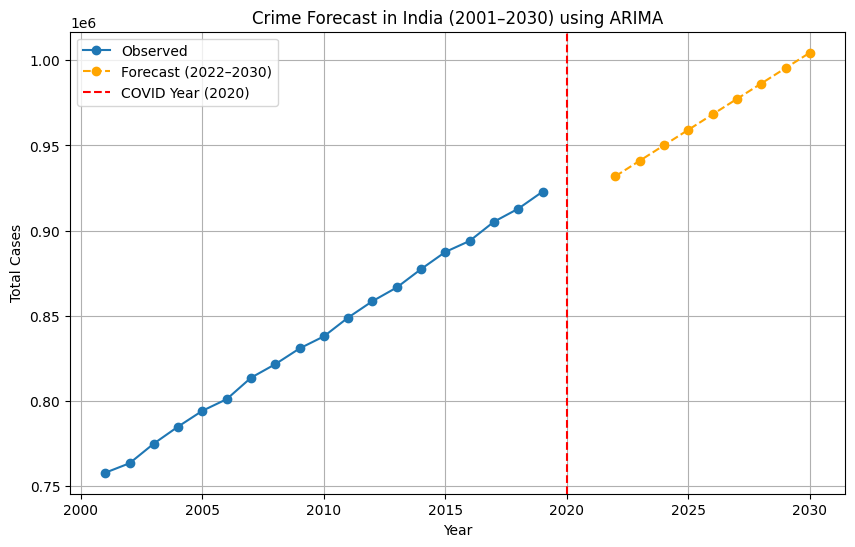

In [ ]:
# Plot observed + forecast
plt.figure(figsize=(10,6))
plt.plot(yearly_total_no2020.index, yearly_total_no2020.values, label="Observed", marker="o")
plt.plot(forecast_series.index, forecast_series.values, label="Forecast (2022–2030)", marker="o", linestyle="--", color="orange")
plt.axvline(x=2020, color='r', linestyle='--', label='COVID Year (2020)')
plt.title("Crime Forecast in India (2001–2030) using ARIMA")
plt.xlabel("Year")
plt.ylabel("Total Cases")
plt.legend()
plt.grid(True)
plt.show()

## Analysis of Crime Forecast (2001–2030)

From the plot and forecasted data:

- The observed crime cases from 2001 to 2020 show a **gradual increase** over the years, with occasional spikes and dips.  
- The year 2020 (COVID year) shows a significant deviation, likely due to lockdowns and reduced reporting.  
- The ARIMA forecast predicts a **continued rise in crime cases from 2022 to 2030**, indicating that without effective interventions, the upward trend may persist.  
- The forecasted increase is steady, reflecting historical patterns while smoothing out sudden fluctuations observed in the past.  

### Conclusion

The ARIMA model suggests that crime in India is likely to **increase gradually over the next decade (2022–2030)**. This insight can help policymakers and law enforcement agencies plan preventive measures and allocate resources effectively to curb crime in the coming years.
